In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 96
import numpy as np
import pandas as pd

# import libraries for biological data analysis
from coolpuppy import coolpup
from coolpuppy.lib import numutils
from coolpuppy.lib.puputils import divide_pups
from coolpuppy import plotpup
import cooler
import bioframe
import cooltools
from cooltools import expected_cis, expected_trans
from cooltools.lib import plotting
import chromoscores.scorefunctions as chrscores


import warnings
warnings.filterwarnings('ignore')


### ctcf peaks

In [2]:
ctcf = bioframe.read_table('/project/fudenber_735/yxiao977/frip_sm_data/ChIP_fastqs_maps/Justice_2020_mm10/SRR10099910/SRR10099910.q30.mm10.sort_peaks.narrowPeak', schema='bed')
ctcf['mid']=(ctcf.end+ctcf.start)/2

### ctcf from JASPAR data

In [3]:
direct='/project/fudenber_735/motifs/mm10/jaspar/MA0139.1.tsv.gz'

In [4]:
ctcfs_motif=bioframe.read_table(direct)

In [5]:
ctcf_motif=ctcfs_motif.rename(columns={0: 'chrom', 1: 'start',2:'end',3:'name',4:'score',5:'pval',6:'strand'})


### overlap

In [6]:
peaks_motifs = bioframe.overlap(ctcf,ctcf_motif,how='inner')

In [7]:
peaks_motifs = peaks_motifs[(peaks_motifs['chrom']!= 'chrX')&(peaks_motifs['chrom']!= 'chrY')]

In [8]:
peaks_motifs=peaks_motifs.rename(columns={'strand':'strand_','strand_':'strand'})

In [9]:
peaks_motifs=peaks_motifs[['chrom','start','end','name','score','mid','strand']]

### picking chromosomes 

In [10]:
peaks_motifs = peaks_motifs[(peaks_motifs['chrom']!= 'chrX')&(peaks_motifs['chrom']!= 'chrY')]

In [11]:
peaks_motifs_cluster = bioframe.cluster(peaks_motifs, min_dist=10000)#

In [12]:
# Group by 'chuster_start' and 'cluster_end' and get the index of rows with the max 'score' within each group
idx = peaks_motifs_cluster.groupby(['cluster_start', 'cluster_end'])['score'].idxmax()

# Filter the dataframe to keep only the rows with the max 'score' in each group
peaks_motifs_bin_s = peaks_motifs_cluster.loc[idx].reset_index(drop=True)

peaks_motifs_bin_s

,chrom,start,end,name,score,mid,strand,cluster,cluster_start,cluster_end
0,chrM,50,1684,SRR10099910.q30.mm10.sort_peak_48675,146,867.0,-,29985,50,1684
1,chr18,3005726,3005978,SRR10099910.q30.mm10.sort_peak_21060,515,3005852.0,-,13137,3005726,3005978
2,chr18,3039488,3039650,SRR10099910.q30.mm10.sort_peak_21061,65,3039569.0,-,13138,3039488,3039650
3,chr14,3050178,3050329,SRR10099910.q30.mm10.sort_peak_13317,95,3050253.5,-,8283,3050178,3050329
4,chr4,3052367,3052649,SRR10099910.q30.mm10.sort_peak_30167,210,3052508.0,+,18804,3052367,3052649
...,...,...,...,...,...,...,...,...,...,...
29981,chr1,194879563,194879893,SRR10099910.q30.mm10.sort_peak_3195,894,194879728.0,+,2082,194879563,194879893
29982,chr1,194962248,194962539,SRR10099910.q30.mm10.sort_peak_3198,478,194962393.5,-,2083,194952981,194962539
29983,chr1,194976166,194976743,SRR10099910.q30.mm10.sort_peak_3199,596,194976454.5,+,2084,194976166,194976743
29984,chr1,195040477,195040747,SRR10099910.q30.mm10.sort_peak_3200,553,195040612.0,+,2085,195040477,195040747


### importing experimental data 

In [13]:
# high-resolution reprocessed publically-available data from Bonev et al. 2017
res = 10_000
bonev_file = '/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_ES.mm10.mapq_30.1000.mcool'
bonev_cooler = cooler.Cooler(bonev_file+'::resolutions/'+str(res))
view_df_bonev = cooltools.lib.make_cooler_view(bonev_cooler)[:19]

In [14]:
# data from Liu& deWit et al. 
prefix_dir_liu = '/project/fudenber_735/GEO/liu_deWit_GSE181848/'
cooler_prefix_liu = prefix_dir_liu
sample_dict_liu ={
    'Wapl-0h':'GSM5512837_HiC.01_WAPL_0h.mcool',
    'Wapl-6h':'GSM5512838_HiC.02_WAPL_6h.mcool'
}
sample='Wapl-6h'
mcool_path_liu =  cooler_prefix_liu + sample_dict_liu[sample]
liu_cooler = cooler.Cooler(mcool_path_liu+'::resolutions/'+str(res))
view_df_liu = cooltools.lib.make_cooler_view(liu_cooler)

In [15]:
# data from Liu 2021
prefix_dir_liu_new = '/project/fudenber_735/GEO/liu_deWit_2021_GSE135180/distiller-mm10/results/coolers_library/'
cooler_prefix_liu_new = prefix_dir_liu_new
sample_dict_liu_new ={
    'Wapl-0h_new':'liu_wapl0h.mm10.mapq_30.1000.mcool',
    'Wapl-24h_new':'liu_wapl24h.mm10.mapq_30.1000.mcool'
}
sample='Wapl-24h_new'
mcool_path_liu_new =  cooler_prefix_liu_new + sample_dict_liu_new[sample]
liu_new_cooler = cooler.Cooler(mcool_path_liu_new+'::resolutions/'+str(res))
view_df_liu_new = cooltools.lib.make_cooler_view(liu_new_cooler)[:19]

### isolation score, observed over expected


In [16]:
import chromoscores.maputils as chrmap
import chromoscores.snipping as chrsnip
import chromoscores.scorefunctions as chrscores

In [17]:
# Bonev et al 2017

INFO:coolpuppy:('chr1', 'chr1'): 2086
INFO:coolpuppy:('chr2', 'chr2'): 2320
INFO:coolpuppy:('chr3', 'chr3'): 1537
INFO:coolpuppy:('chr4', 'chr4'): 1949
INFO:coolpuppy:('chr5', 'chr5'): 2140
INFO:coolpuppy:('chr6', 'chr6'): 1759
INFO:coolpuppy:('chr7', 'chr7'): 1909
INFO:coolpuppy:('chr8', 'chr8'): 1665
INFO:coolpuppy:('chr9', 'chr9'): 1748
INFO:coolpuppy:('chr10', 'chr10'): 1550
INFO:coolpuppy:('chr11', 'chr11'): 2074
INFO:coolpuppy:('chr12', 'chr12'): 1280
INFO:coolpuppy:('chr13', 'chr13'): 1283
INFO:coolpuppy:('chr14', 'chr14'): 1271
INFO:coolpuppy:('chr15', 'chr15'): 1221
INFO:coolpuppy:('chr16', 'chr16'): 1059
INFO:coolpuppy:('chr17', 'chr17'): 1297
INFO:coolpuppy:('chr18', 'chr18'): 915
INFO:coolpuppy:('chr19', 'chr19'): 889
INFO:coolpuppy:Total number of piled up windows: 29952


i is 0
score is 1.1191465816344541
i is 1
score is 1.1124794751488274
i is 2
score is 1.1158979854136395


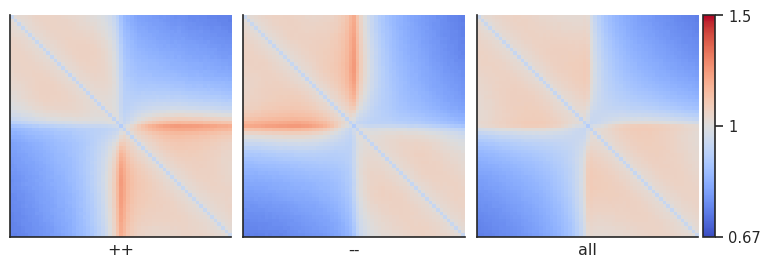

In [53]:
sites=peaks_motifs_bin_s.copy()
clr = bonev_cooler
pseudocount = 10./clr.info['sum']
pseudocount_a = 0
sites=peaks_motifs_bin_s.copy()
clr = bonev_cooler
pseudocount = 10./clr.info['sum']
pseudocount = 0
expected = expected_cis(
    clr,
    ignore_diags=0,
    view_df=view_df_bonev[:19],
    chunksize=1000000)

pup = coolpup.pileup(clr, sites, features_format='bed', expected_df=expected,view_df=view_df_bonev[:19], local=True,
                    by_strand=True,
                    flank=300_000, min_diag=0
                    )
scr=[]
delta_val = 1
diag_offset_val = 5
max_distance_val = 30
for i in range(len(pup['data'])):
    print('i is %s'%i)
    #a,b,pile_c=get_isolated_regions(pup['data'][i],24,1,3,15)
    pile = pup['data'][i]
    score=chrscores.isolation_score(pile,delta=delta_val,diag_offset=diag_offset_val,max_dist=max_distance_val,
                                    snippet_shapes='triangle',
                                    pseudo_count=pseudocount)
    scr.append(score)
    print('score is %s'%score)
    

plotpup.plot(pup,
         cols='orientation', col_order=['++', '--','all'],
         score=False, cmap='coolwarm', scale='log', sym=True, vmax=1.5,
         height=3)


plt.savefig('output/figures/ondiagonal_for_bonev.pdf')
plt.show()

In [18]:
# Liu et al

INFO:coolpuppy:('chr1', 'chr1'): 2086
INFO:coolpuppy:('chr10', 'chr10'): 1550
INFO:coolpuppy:('chr11', 'chr11'): 2074
INFO:coolpuppy:('chr12', 'chr12'): 1280
INFO:coolpuppy:('chr13', 'chr13'): 1283
INFO:coolpuppy:('chr14', 'chr14'): 1271
INFO:coolpuppy:('chr15', 'chr15'): 1221
INFO:coolpuppy:('chr16', 'chr16'): 1059
INFO:coolpuppy:('chr17', 'chr17'): 1297
INFO:coolpuppy:('chr18', 'chr18'): 915
INFO:coolpuppy:('chr19', 'chr19'): 889
INFO:coolpuppy:('chr2', 'chr2'): 2320
INFO:coolpuppy:('chr3', 'chr3'): 1537
INFO:coolpuppy:('chr4', 'chr4'): 1949
INFO:coolpuppy:('chr5', 'chr5'): 2140
INFO:coolpuppy:('chr6', 'chr6'): 1759
INFO:coolpuppy:('chr7', 'chr7'): 1909
INFO:coolpuppy:('chr8', 'chr8'): 1665
INFO:coolpuppy:('chr9', 'chr9'): 1748
INFO:coolpuppy:Total number of piled up windows: 29952


i is 0
score is 1.144169869759504
i is 1
score is 1.1334198103247957
i is 2
score is 1.1388671986220822


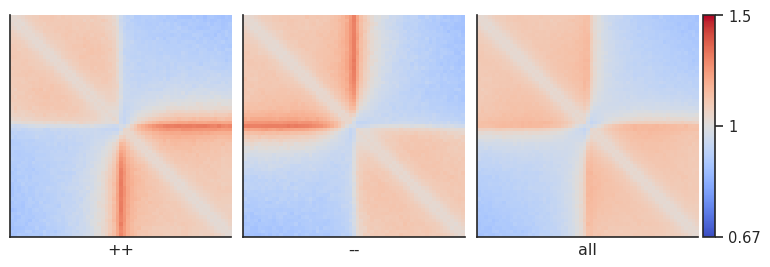

INFO:coolpuppy:('chr1', 'chr1'): 2086
INFO:coolpuppy:('chr10', 'chr10'): 1550
INFO:coolpuppy:('chr11', 'chr11'): 2074
INFO:coolpuppy:('chr12', 'chr12'): 1280
INFO:coolpuppy:('chr13', 'chr13'): 1283
INFO:coolpuppy:('chr14', 'chr14'): 1271
INFO:coolpuppy:('chr15', 'chr15'): 1221
INFO:coolpuppy:('chr16', 'chr16'): 1059
INFO:coolpuppy:('chr17', 'chr17'): 1297
INFO:coolpuppy:('chr18', 'chr18'): 915
INFO:coolpuppy:('chr19', 'chr19'): 889
INFO:coolpuppy:('chr2', 'chr2'): 2320
INFO:coolpuppy:('chr3', 'chr3'): 1537
INFO:coolpuppy:('chr4', 'chr4'): 1949
INFO:coolpuppy:('chr5', 'chr5'): 2140
INFO:coolpuppy:('chr6', 'chr6'): 1759
INFO:coolpuppy:('chr7', 'chr7'): 1909
INFO:coolpuppy:('chr8', 'chr8'): 1665
INFO:coolpuppy:('chr9', 'chr9'): 1748
INFO:coolpuppy:Total number of piled up windows: 29952


i is 0
score is 1.126636054087945
i is 1
score is 1.1058982693224064
i is 2
score is 1.1163322258421158


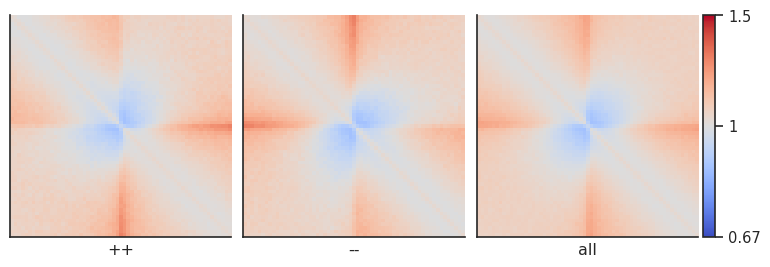

In [20]:
sites=peaks_motifs_bin_s.copy()

csv_file = "../output/scores/experiments/experimental_data_table.csv"
df = pd.read_csv(csv_file)
for sample in sample_dict_liu:
    mcool_path_liu =  cooler_prefix_liu + sample_dict_liu[sample]
    liu_cooler = cooler.Cooler(mcool_path_liu+'::resolutions/'+str(res))
    view_df_liu = cooltools.lib.make_cooler_view(liu_cooler)
    view_df_liu = view_df_liu[view_df_liu['chrom'].isin(view_df_bonev['chrom'])]
    view_df_liu_sort = view_df_liu.reset_index(drop=True)
    
    clr = liu_cooler
    pseudocount = 10./clr.info['sum']
    pseudocount =0
    expected = expected_cis(
        clr,
        ignore_diags=0,
        view_df=view_df_liu_sort,
        chunksize=1000000)
    
    pup = coolpup.pileup(clr, sites, features_format='bed', expected_df=expected,view_df=view_df_liu_sort, local=True,
                        by_strand=True,
                        flank=300_000, min_diag=0
                        )

    scr=[]
    delta_val = 1
    diag_offset_val = 5
    max_distance_val = 30
    for i in range(len(pup['data'])):
        print('i is %s'%i)
        pile = pup['data'][i]
        score=chrscores.isolation_score(pile,delta=delta_val,diag_offset=diag_offset_val,max_dist=max_distance_val,
                                        snippet_shapes='triangle',
                                        pseudo_count=pseudocount)
        scr.append(score)
        print('score is %s'%score)
        #print('average is %s'%(np.mean(a[a>0])/np.mean(b[b>0])))

    # writing to the file
    if sample == 'Wapl-0h':
        condition = (df['measurement'] == 'Isolation') & (df['paper'] == 'Liu_2020') & (df['condition'] == 'WT')
        df.loc[condition, 'value'] = score
    elif sample == 'Wapl-6h':
        condition = condition = (df['measurement'] == 'Isolation') & (df['paper'] == 'Liu_2020') & (df['condition'] == 'Wapl_6h')
        df.loc[condition, 'value'] = score    
    df.to_csv(csv_file, index=False)
    plotpup.plot(pup,
             cols='orientation', col_order=['++', '--','all'],
             score=False, cmap='coolwarm', scale='log', sym=True, vmax=1.5,
             height=3)
    
    
    plt.savefig('../output/figures/ondiagonal_for_liu_%s.pdf'%sample)
    plt.show()

In [48]:
# Liu et al 2021

In [ ]:
sites=peaks_motifs_bin_s.copy()

for sample in sample_dict_liu_new:
    mcool_path_liu_new =  cooler_prefix_liu_new + sample_dict_liu_new[sample]
    liu_cooler_new = cooler.Cooler(mcool_path_liu_new+'::resolutions/'+str(res))
    view_df_liu_new = cooltools.lib.make_cooler_view(liu_cooler_new)[:19]
    
    clr = liu_cooler_new
    pseudocount = 10./clr.info['sum']
    pseudocount = 0
    expected = expected_cis(
        clr,
        ignore_diags=0,
        view_df=view_df_liu_new[:1],
        chunksize=1000000)
    
    pup = coolpup.pileup(clr, sites, features_format='bed', expected_df=expected,view_df=view_df_liu_new[:1], local=True,
                        by_strand=True,
                        flank=300_000, min_diag=0
                        )

    scr=[]
    delta_val = 1
    diag_offset_val = 5
    max_distance_val = 30
    for i in range(len(pup['data'])):
        print('i is %s'%i)
        pile = pup['data'][i]
        score=chrscores.isolation_score(pile,delta=delta_val,diag_offset=diag_offset_val,max_dist=max_distance_val,
                                        snippet_shapes='triangle',
                                        pseudo_count=pseudocount)
        scr.append(score)
        print('score is %s'%score)
        
    
    plotpup.plot(pup,
             cols='orientation', col_order=['++', '--','all'],
             score=False, cmap='coolwarm', scale='log', sym=True, vmax=1.5,
             height=3)
    
    plt.savefig('output/figs/ondiagonal_for_liu_new_%s.pdf'%sample)
    plt.show()